In [13]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [3]:
## The output of torchvision datasets are PILImage images of range [0, 1]. 
## We transform them to Tensors of normalized range [-1, 1]



transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


  car   cat  ship  ship


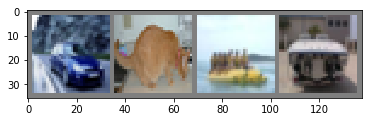

In [16]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [19]:
## deining a CNN network to take 3-channel input
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
## Let's use classification Cross-Entropy loss and SGD optimizer
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
## let's loop over our data iterator and train the network

for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
        inputs, labels = Variable(inputs), Variable(labels)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.200
[1,  4000] loss: 1.845
[1,  6000] loss: 1.687
[1,  8000] loss: 1.568
[1, 10000] loss: 1.512
[1, 12000] loss: 1.469
[2,  2000] loss: 1.394
[2,  4000] loss: 1.368
[2,  6000] loss: 1.357
[2,  8000] loss: 1.331
[2, 10000] loss: 1.307
[2, 12000] loss: 1.281
Finished Training


GroundTruth:    cat  ship  ship plane


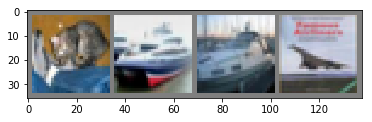

In [22]:
## Image dataset
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [25]:
## what our neural network thin of these class
outputs = net(Variable(images))
outputs

Variable containing:
-1.3062 -2.4919  0.4635  3.0018 -0.4364  2.5629  1.0409 -0.7799 -0.1287 -1.6652
 6.3323  8.1105 -2.8486 -2.8411 -3.4280 -4.9559 -4.3431 -4.3311  6.5104  5.6229
 4.2370  5.0890 -1.2850 -1.6427 -2.1093 -3.0576 -2.9808 -2.5646  4.2806  3.0480
 4.3323  2.4713 -0.2991 -1.0757 -1.1904 -3.0327 -3.0721 -2.5731  4.2638  1.8609
[torch.FloatTensor of size 4x10]

In [26]:
## Each class ahs probability of belonging to particular class
## it belong to the class with maximum probability

_, predicted = torch.max(outputs.data, 1)
print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat   car   car plane


In [27]:
# Let us look at how the network performs on the whole dataset.
correct = 0
total = 0
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


- Random acuracy for this test will be 10%; the network is doing pretty better than random chance
- We can check what classes are doing better and what classes are not doing better

In [28]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
for data in testloader:
    images, labels = data
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    
    for i in range(4):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 59 %
Accuracy of   car : 73 %
Accuracy of  bird : 40 %
Accuracy of   cat : 39 %
Accuracy of  deer : 40 %
Accuracy of   dog : 34 %
Accuracy of  frog : 65 %
Accuracy of horse : 66 %
Accuracy of  ship : 74 %
Accuracy of truck : 63 %


- I am leaving the part about training in GPU; will do one session on GPU separately